In [10]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [11]:

class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()

In [12]:
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

In [13]:

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

In [ ]:
game = Gridworld(size=4, mode='static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:
game.reward()

-1

In [ ]:

game.board.render_np()

array([[[0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [ ]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [ ]:
epochs = 1000
losses = [] #A # 손실을 관찰하기 위해 손실을 리스트에 담는다.
for i in range(epochs): #B 
# epochs 만큼 게임을 반복한다.
    game = Gridworld(size=4, mode='static') #C 
    # 게임을 'static' 방식으로 시작한다.
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #D
    # 현재 상태를 numpy 배열로 표현하고 1,64 배열로 정돈한다.
    # 그리고 죽은 셀을 방지하기 위해 잡음을 조금 넣어준다.
    state = torch.from_numpy(state_).float() #E
    # 현재 상태에 대한 numpy 배열을 pytorch 에서 사용가능한 배열로 바꿔준다. (float())
    state1 = torch.from_numpy(state_).float()
    # 현재 상태를 state1 에 담아준다.
    status = 1 #F
    # 초기상태를 1로 지정을 한다. (이기거나 지면 status 값이 바뀐다.)
    while(status == 1): #G
    # 이기거나 지지 않은 상태일 경우
        qval = model(state1) #H
        # 첫번째로, model(인공신경망)이 가치예측판단을 한다.
        qval_ = qval.data.numpy()
        # 4개의 선택에 대해서 어느정도의 예상보상이 있는지 출력한 것을
        # numpy 배열로 바꿔준다.
        if (random.random() < epsilon): #I
            action_ = np.random.randint(0,4)
            # epsilon 의 확률로 랜덤행동을 하고,
        else:
            action_ = np.argmax(qval_)
            # 그 외의 확률로는 신경망이 판단한 최선의 선택을 한다.
        
        action = action_set[action_] #J
        # 해당 행동 numpy 를 'u','d','l','r' 형태의 문자열로 변경해준다.
        game.makeMove(action) #K
        # 해당 문자열로 움직인다.
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        # 움직이고 난 상태를 numpy로 바꾸고, 1,64 배열로 바꿔준 후 잡음을 더해 state2 에 저장해준다.
        state2 = torch.from_numpy(state2_).float() #L
        # 상태2를 pytorch 형 배열로 바꾼 다음 state2 에 담아준다.
        reward = game.reward()
        # state2 에서의 보상을 업데이트 시켜준다.
        with torch.no_grad():
          # 결과값만을 얻기 위해 no_grad 를 해준다. (역전파가 필요 없는 경우)
            newQ = model(state2.reshape(1,64))
            # 상태2 에서 신경망이 판단한 보상예측을 newQ에 담는다.
        maxQ = torch.max(newQ) #M
        # 상태2 에서의 최선의 보상을 maxQ(최대 보상)에 대입한다.
        if reward == -1: #N
        # 만약 reward 가 -1, 즉 이동만 하고 구덩이나 +를 밟지 않은 경우라면
            Y = reward + (gamma * maxQ)
            # 보상에 gamma(시간상쇄지수)*최대보상을 더해준다.
        else:
            Y = reward
            # 만약 구덩이나 +를 밟은 경우라면 Y에 보상을 바로 집어넣는다.
        Y = torch.Tensor([Y]).detach()
        # .detach() 는 해당 텐서를 복사해주는 기능이다. (복사된 텐서는 gradient 전파가 안된다.)
        # no_grad 와 detach 는 똑같다. 둘 다 requires_grad 를 False 로 만들어주는 기능.
        # 따라서 Y에 보상값을 torch 텐서로 변형해준 값을 복사해서 담아준다.
        
        X = qval.squeeze()[action_] #O
        # squeeze 메소드는 더미의 차원을 추가하는 기능이고,
        # unsqueeze 는 더미의 차원을 삭제하는 기능이다.
        # 즉 여기선 qval 이라는 가치판단 함수에 행동[0 0 1 0]을 넣어주게 된다.
        # 그래서 해당 행동을 했다는 것을 알리기 위함이다.
        # 여기서 action_ 예를 들면 2번 행동을 했으면,
        # 2번 행동에 해당하는 가치값을 X에 대입해줌을 말한다.

        loss = loss_fn(X, Y) #P
        # qval = model(state1), Y =torch.Tensor([reward (+ gamma*maxQ 선택)])
        # 즉 신경망이 예측한 보상들과 실제 보상들의 손실을 계산한다.
        # X는 qval(신경망이 기대한 가치들)에서 해당 행동에 해당하는 기대되는 가치를 대입한 값이고,
        # Y는 실제 보상이다.
        # 그래서 그 기대값과 실제 보상을 손실함수를 통해 손실을 구하고,
        # 이를 나중에 역전파 해서 신경망의 가중치를 바꾼다.

        print(i, loss.item())
        # 게임 횟수에 따른 손실값을 출력한다.
        clear_output(wait=True)
        # 화면에 출력된걸 다 지워서 깔끔하게 만든다.
        optimizer.zero_grad()
        # 최적기안에 탑재된 매개변수를 모두 0으로 만든다. 
        # 이게 왜 필요한가?
        # 파이토치는 미분을 통해 얻은 기울기를 이전에 계산된 기울기 값에 누적시키는 특징이 있다.
        # 따라서 매회마다 초기화를 시켜줘야 한다. (? 이해 안감.)
        # no_grad 와 zero_grad 는 다름.
        # zero_grad 는 초기화고, no_grad 는 아예 gradient 를 만들지 않도록 설정함.

        loss.backward()
        # 계산을 통해 얻은 grad(경사)을 통해서 
        # model의 매개변수를 역전파를 하는 기능. 
        losses.append(loss.item())
        # 손실을 담아준다. ( loss.item() 은 손실함수에서 손실값을 산출하는 기능이다. )
        optimizer.step()
        # optimizer 은 계산을 통해 축적된 손실과 grad 을 통해 model 안의 모든 tensor 을 순환하여 
        # 가중치를 조정하고
        # 이로 인해 model 은 진화한다.
        state1 = state2
        # 상태 1을 2로 바꿔준다.
        if reward != -1: #Q
            status = 0
            # 만약 구덩이에 빠졌거나 이겼으면 status = 0으로 한다.
    if epsilon > 0.1: #R
        epsilon -= (1/epochs)
        # epsilon 값을 횟수가 지나가면 지나갈수록 갱신해준다.
        # 초기입실론값 - 1/1000 - 1/1000 ... 

999 0.013151569291949272


Text(0, 0.5, 'Loss')

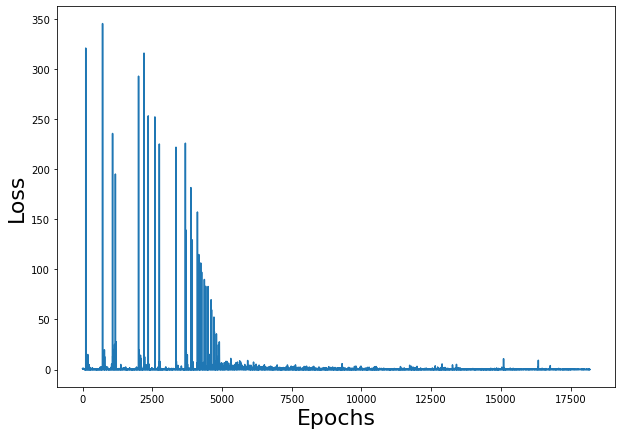

In [ ]:
# 손실의 변화 추이를 찍어서 관찰하자.

plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [14]:
def test_model(model, mode='random', display=True):
  # 모델을 테스트하는 함수를 만든다. (게임만 돌리고 학습은 안한다.)
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        # 각각의 행동들의 기대가치가 담긴 리스트를 qval_에 담는다.
        action_ = np.argmax(qval_) #B
        # 그리고 기대가치가 가장 높은 행동의 인덱스를 추출한다.
        action = action_set[action_]
        # 해당 인덱스를 문자열로 변환해준다.
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        # 움직이기
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        # 그 다음 환경 세팅
        state = torch.from_numpy(state_).float()
        # 환경을 토치가 인식할 수 있도록 .float() 변환
        if display:
            print(test_game.display())
        reward = test_game.reward()
        # 행동 했으니 보상을 담는다.
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    # status 가 바뀔때까지 계속 while 돌아간다.
    # 그리고 test_model 은 state1, state2 따로 저장하지 않는다.
    # 손실을 구할 필요도 없고, 단순히 이동만 하면 되기 때문이다.

    win = True if status == 2 else False
    return win

In [ ]:
# 신경망을 테스트하는 함수
test_model(model)

Initial State:
[['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [ ]:
# 하지만 위의 경우는 패턴이 같은 게임은 학습할 수 있지만,
# 패턴이 바뀌는 게임의 경우엔 학습이 이루어지지 않는다.
# 오른쪽으로 이동했을 때 보상을 받던게,
# 지형이 바뀌면 오른쪽으로 똑같게 이동했는데 패널티를 받는 경우가 생긴다.
# 그 경우 모델이 학습한 것을 다시 되돌리게 되고,
# 결국엔 전체적으로 학습이 이루어지지 않는다.

# 이를 파국적 망각(Catastrophic forgetting) 이라고 한다.
# 이를 해결하기 위해서는 한판 한판의 데이터를 학습하지 말고,
# 여러 판들(batch size - 대략 200개 이상)의 데이터를 모아서,
# 그중에서 랜덤하게 뽑아 적당한 부분집합 (대충 30개)를 뽑아서,
# 이 30개 부분집합 전체에 대한 합 또는 평균 기울기를 계산 하고,
# 이를 한꺼번에 학습(가중치들을 갱신)시키는 것이다.

# 따라서, 랜덤한 경우를 해결하기 위한 방법으로 경험재현(Experience replay) 기법이 존재한다.

# 기존의 온라인 학습(한번 한번 학습)에 배치 훈련 방식(부분집합으로 훈련)을 도입하는 것이다.


In [15]:
# 인공신경망 만들기
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [16]:
# 이제 경험재현기법을 적용한다.
from collections import deque
import numpy as np

In [ ]:

epochs = 5000
losses = []
mem_size = 1000 # 기억을 담을 수 있는 최대 공간. (뇌용량)
batch_size = 200 # 그 기억중에서 몇개를 주기적으로 학습할 것이냐.
replay = deque(maxlen = mem_size) # deque 는 왜 쓰는거지?
max_moves = 50 # 50회 이상 움직이면 게임 종료.
h = 0 # 이건 또 뭐지?

for i in range(epochs): # 5000번까지 게임을 돌린다.
  game = Gridworld(size=4, mode='random')
  # 4*4 사이즈 게임판 만들어주고
  state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  # 상태 ndarray 형태로 담아주고
  state1 = torch.from_numpy(state1_).float()
  # torch 가 인식할 수 있도록 torch 전용 데이터로 변환(.float())
  status = 1
  # 이제 게임 시작!
  mov=0 # 움직임 수 초기화

  while(status==1):
    mov+=1 
    qval = model(state1)
    qval_ = qval.data.numpy()
    # 파이토치에 있는 값을 ndarray 로 다시 변환한다.
    if (random.random()<epsilon):
      action_ = np.random.randint(0,4)
    else:
      action_ = np.argmax(qval_)
    # 입실론을 통해 무작위 행동을 할지, 최적의 선택을 할지 설정한다.
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    done = True if reward>0 else False
    exp = (state1, action_, reward, state2, done)
    replay.append(exp)
    state1 = state2

    if len(replay)>batch_size:
      minibatch = random.sample(replay, batch_size)
      # 미니배치를 랜덤하게 뽑는다.
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])

      Q1 = model(state1_batch)
      with torch.no_grad():
        Q2 = model(state2_batch)
      
      Y = reward_batch + gamma*((1-done_batch)*torch.max(Q2, dim=1)[0])
      # 상태2 에서의 기대보상
      X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
      # 상태1 에서의 기대보상

      loss = loss_fn(X, Y.detach())
      optimizer.zero_grad()
      # 최적화기 리셋

      loss.backward()
      # 손실로 역전파
      losses.append(loss.item())
      # 손실을 losses 리스트에 담아준다.
      optimizer.step()
      # optimizer 진화시키기

    if reward != -1 or mov>max_moves:
      # 판이 끝났거나 게임횟수가 50번 넘어가는 경우
      status = 0
      mov = 0

losses = np.array(losses)



In [ ]:
max_games = 1000
wins = 0
for i in range(max_games):
  win = test_model(model, mode='random', display=False)
  if win:
    wins += 1
win_perc = float(wins)/float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games, wins))
print("Win percentage: {}".format(win_perc))

Games played: 1000, # of wins: 484
Win percentage: 0.484


In [17]:
import copy
# 정책망을 만들기 위해 신경망을 복사할 때 쓸 것.

In [18]:
model = torch.nn.Sequential(
    torch.nn.Linear(l1,l2)
    , torch.nn.ReLU()
    , torch.nn.Linear(l2,l3)
    , torch.nn.ReLU()
    , torch.nn.Linear(l3,l4)
)

model2 = copy.deepcopy(model)
# 주 Q 신경망을 그대로 복제해서 목표망을 만든다.
model2.load_state_dict(model.state_dict())
# 주 Q 신경망의 매개변수들을 복사한다.

loss_fn = torch.nn.MSELoss()
# 손실함수를 규정해주고,
learning_rate = 1e-3
# 학습율을 0.001 로 맞춰주고,
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 초기화 과정

gamma = 0.9
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [23]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen = mem_size)
max_moves = 50
h = 0
sync_freq = 500
j=0

for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state1_ = game.board.render_np().reshape(1,64)+np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state1_).float()
  status=1
  mov=0
  # 게임판을 만들고, 초기 상태를 지정한다.

  while(status==1):
    j += 1
    mov += 1
    qval = model(state1)
    # 현재 상태에서 각 움직임의 기대가치를 가져온다.
    qval_ = qval.data.numpy()
    # 기대가치들의 리스트를 numpy 로 변환해준다.

    if (random.random() < epsilon):
      # epsilon의 확률로 랜덤동작을 수행한다.
      action_ = np.random.randint(0,4)
    else:
      # 랜덤동작이 아닐 경우 최선의 선택을 고른다. 
      action_ = np.argmax(qval_)

    action = action_set[action_]
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    
    done = True if reward > 0 else False
    # reward > 0 이면 게임이 끝났음을 저장한다.
    exp = (state1, action_, reward, state2, done)
    replay.append(exp)
    state1 = state2

    if len(replay) > batch_size:
      # 경험재현 리스트에 해당 배치 이상이 쌓이면
      # 경험재현기법을 시작한다.
      minibatch = random.sample(replay, batch_size)
      # 경험리스트에 배치사이즈만큼 샘플을 뽑아 minibatch 에 담는다.
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])

      Q1 = model(state1_batch)
      with torch.no_grad():
        Q2 = model(state2_batch)
        # 상태2 에서의 기대치들은 grad 가 필요 없음. (단순히 손실계산을 위한 것)
      
      Y = reward_batch + gamma*((1-done_batch)*torch.max(Q2, dim=1)[0])
      X = Q1.gather(dim=1, index = action_batch.long().unsqueeze(dim=1)).squeeze()

      loss = loss_fn(X,Y.detach()) 
      
      print(i,loss.item())
      clear_output(wait=True)
      optimizer.zero_grad()
      # 최적화기의 매개변수를 0으로 초기화시킨다.
      loss.backward() 
      # 손실을 통해 역전파를 시행한다.
      losses.append(loss.item())
      # 손실을 리스트에 추가한다.
      optimizer.step()
      # 최적화기를 발전시킨다.

      if j%sync_freq:
        # 500회마다 신경망 카피
        model2.load_state_dict(model.state_dict())
      
      if reward != -1 or mov > max_moves:
        status = 0
        mov = 0
      
losses = np.array(losses)




4999 9.903529644361697e-06
